<div dir="rtl">

## 🔷 ما هي خوارزمية K-Means؟

خوارزمية **K-Means** هي إحدى أشهر خوارزميات التعلم غير المُوجّه (Unsupervised Learning)، وتستخدم لتجميع البيانات في مجموعات (Clusters) بناءً على التشابه بين القيم.  
تعمل الخوارزمية على تقسيم البيانات إلى **K مجموعات** بحيث تكون العناصر داخل كل مجموعة متشابهة قدر الإمكان، ومختلفة عن المجموعات الأخرى.

---

## ✅ مميزات خوارزمية K-Means

- **سهلة وسريعة** في التدريب والتطبيق.  
- مناسبة للبيانات الكبيرة (Large Datasets).  
- تعمل جيدًا عندما تكون المجموعات واضحة وقابلة للفصل.  
- فعّالة في تصنيف الصور، خاصة صور الأقمار الصناعية.  

---

## ❗ عيوب خوارزمية K-Means

- يجب **تحديد عدد المجموعات (K)** مسبقًا، وهذا أحيانًا يكون غير واضح.  
- تتأثر بالقيم الشاذة (Outliers).  

---

## 🎯 حالات الاستخدام المناسبة لـ K-Means

- **تصنيف الغطاء الأرضي (Land Cover Classification)** باستخدام صور الأقمار الصناعية.  
- اكتشاف الأنماط في البيانات الجغرافية.  
- تجميع البيكسلات ذات القيم الطيفية المتشابهة.  
- تحليل الصور، فصل الألوان، واستخراج السمات الطيفية.  
- تقسيم الأراضي إلى فئات (ماء – نبات – مباني – تربة…إلخ).  
- أي مهمة تحتاج إلى تجميع بدون وجود بيانات تدريب (Labels).

</div>


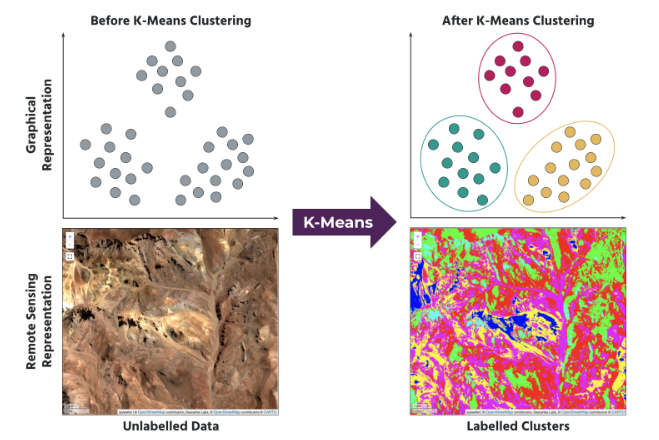

## 🔷 The Workflow: K-Means Land Cover Classification (Landsat-8)

### 1. Define Study Area  
Select the location or boundary for analysis.

### 2. Load Landsat-8 Surface Reflectance Data  
Filter by date range, cloud percentage, and required spectral bands.

### 3. Preprocessing  
- **Cloud Masking:** Remove clouds and cloud shadows using the QA band.  
- **Median Composite:** Create a cloud-free composite to reduce noise.

### 4. Instantiate the K-Means Clusterer  
Define the number of clusters (K) and initialize the K-Means model.

### 5. Train and Apply K-Means  
Train the model on the prepared image data and assign each pixel to a cluster.

### 6. Generate the Classified Map  
Apply a color palette and add labels for each class.

### 7. Visualize & Export  
Display the final classified map and export the GeoTIFF


In [ ]:
# Install & Import Libraries
! pip install eemont

import ee
import geemap
import eemont

In [ ]:
# Authenticate to Earth Engine.
ee.Authenticate()

# Initialize Earth Engine with your project ID
ee.Initialize(project =  'ee-nouribrahim25')

Define AOI

In [ ]:
coors = [[29.822395, 30.608354],
    [29.822395, 30.754805],
    [30.098427, 30.754805],
    [30.098427, 30.608354],
    [29.822395, 30.608354]]

aoi = ee.Geometry.Polygon(coors)


In [ ]:
Map = geemap.Map(width = 800)
Map.centerObject(aoi , 11)
Map.add_layer(aoi , {} , 'AOI')

In [ ]:
# Define the bands needed for classification and index calculation
bands = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','QA_PIXEL']
indices = ['NDVI','NDWI','NDBI']

# Final list of features for the classifier
features = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'] + indices

Create cloud-free median composite

In [ ]:
def cloud_mask(image):
  qa = image.select('QA_PIXEL')

  dilated = qa.bitwiseAnd(1 << 1).eq(0)
  cirrus  = qa.bitwiseAnd(1 << 2).eq(0)
  cloud   = qa.bitwiseAnd(1 << 3).eq(0)
  shadow  = qa.bitwiseAnd(1 << 4).eq(0)
  mask = dilated.And(cirrus).And(cloud).And(shadow)

  # Apply scaling for SR bands
  scaled = image.select(bands).multiply(0.0000275).add(-0.2)

  return image.addBands(scaled, overwrite=True).updateMask(mask)



In [ ]:
land8 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterBounds(aoi)
        .filterDate('2024-11-01','2025-5-01')
        .filter(ee.Filter.lt('CLOUD_COVER',40))
        .select(bands)
        .map(cloud_mask)
        .spectralIndices(indices)     # Compute indices with eemont
        .median()
        .clip(aoi)
        )

land8

In [ ]:
# Add data to the map
vis = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
}

Map.add_layer(land8, vis, 'Landsat 8 True')


Make training dataset

In [ ]:
image = land8.select(features)
image

In [ ]:
# Sampling for K-Means Training
training = image.sample(**{
    'region': aoi,
    'scale' : 30 ,
    'numPixels': 5000,
    'seed':42,
    'geometries': True
})

print("Training samples:", training.size().getInfo())

Map.add_layer(training , {} , 'Training' , False)



Instantiate and train the clusterer

In [ ]:
# K-Means Clustering
n_clusters = 6
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)
result = image.cluster(clusterer)

Classify the image

In [ ]:
# input clustring with the clusterer
result = image.cluster(clusterer)

class_vis = {'min':0 , 'max':5 , 'palette':['green','red', 'blue', 'yellow', 'purple' , 'Cyan' ]}

# add the clusters layer
Map.add_layer(result, class_vis , 'Clusters')
Map

cluster labeling

In [ ]:
# Combine class labels and colors into a single dictionary
class_map = {
    2: {'label': 'Water', 'color': '#0000FF'},         #Blue
    3: {'label': 'Mixed/ Shadow', 'color': '#00FFFF'}, #Cyan
    5: {'label': 'Bare Soil', 'color': '#8B4513'},     #Brown
    4: {'label': 'Urban / Road', 'color': '#FF0000'},  #Red
    0: {'label': 'Vegetation', 'color': '#228B22'},    #Green
    1: {'label': 'Sandy', 'color': '#FFFF00'}          #Yellow
}



In [ ]:
import collections

# Sort the class_map by keys (cluster numbers)
class_map = collections.OrderedDict(sorted(class_map.items()))

# Display the sorted dictionary
display(class_map)

In [ ]:
# Extract colors and labels with list comprehension

# Extract the colors
extracted_colors = [item['color'] for item in class_map.values()]
display(extracted_colors)

#Extract the labels
extracted_labels = [item['label'] for item in class_map.values()]
display(extracted_labels)

Add labeled clusters layer to the map

In [ ]:
Map.remove_legends()  # Clear any existing legends

# Ensure the map layer uses the correct palette
Map.add_layer(result, {'min': 0, 'max': 5, 'palette': extracted_colors}, 'Labeled Clusters')

# Construct legend dictionary
legend_dict = dict(zip(extracted_labels, extracted_colors))

# Add the legend using the constructed dictionary
Map.add_legend(
    legend_dict=legend_dict,
    position='bottomright'
)
Map

Export the result to Drive

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=result,
    description='KMeans_Classification_Image',
    folder='GEE_Exports',
    fileNamePrefix='classified_image',
    scale=30,

)

task.start()